Processed data shape: (60131, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60131 entries, 0 to 60130
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  60131 non-null  float64
 1   humidity     60131 non-null  float64
 2   weather      60131 non-null  object 
dtypes: float64(2), object(1)
memory usage: 1.4+ MB
None
   temperature  humidity weather
0     9.472222      0.89    Cold
1     9.355556      0.86    Cold
2     9.377778      0.89    Cold
3     8.288889      0.83    Cold
4     8.755556      0.83    Cold

Class distribution:
weather
Cold     42757
Sunny    17374
Name: count, dtype: int64
Epoch 1/5
2406/2406 [==============================] - 20s 8ms/step - loss: 0.1370 - accuracy: 0.9666 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 2/5
2406/2406 [==============================] - 18s 8ms/step - loss: 0.0045 - accuracy: 0.9997 - val_loss: 2.8389e-04 - val_accuracy: 1.0000
Epoch 3/5
2406/24

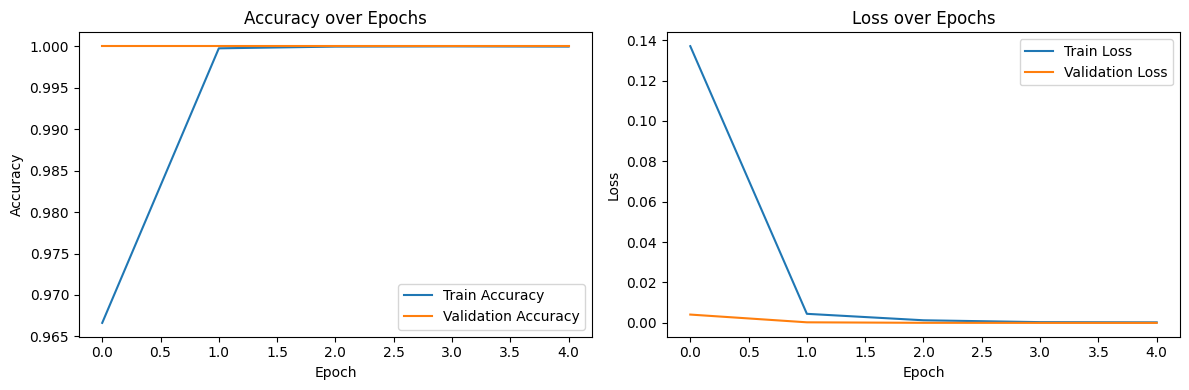


Test Accuracy: 1.0000
376/376 [==============================] - 1s 2ms/step
Average inference time: 0.0931 ms per sample


In [5]:
# notebooks/3_model_training.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, 
                           precision_score, recall_score, f1_score, 
                           roc_auc_score, accuracy_score)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the preprocessed data
data_path = r"D:\FCDS\semster 8\IOT 2\Projects\project 2\tinyml-weather-classification\data\labeled\weather_data.csv"
df = pd.read_csv(data_path)

# Display basic info
print("Processed data shape:", df.shape)
print(df.info())
print(df.head())

# Check class distribution
print("\nClass distribution:")
print(df['weather'].value_counts())

# Prepare features and labels
X = df[['temperature', 'humidity']].values
y = df['weather'].map({'Sunny': 1, 'Cold': 0}).values  # Convert to binary (0: Cold, 1: Sunny)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a more compact model suitable for TinyML
model = Sequential([
    Dense(8, activation='relu', input_shape=(2,)),
    Dropout(0.1),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with a lower learning rate for better stability
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model and measure training time
start_train = time.time()
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)
train_time = time.time() - start_train
print(f"\nTraining completed in {train_time:.2f} seconds")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Make predictions and measure inference speed
start_inference = time.time()
y_pred = (model.predict(X_test) > 0.5).astype(int)
inference_time = (time.time() - start_inference) / len(X_test) * 1000  # ms per sample
print(f"Average inference time: {inference_time:.4f} ms per sample")

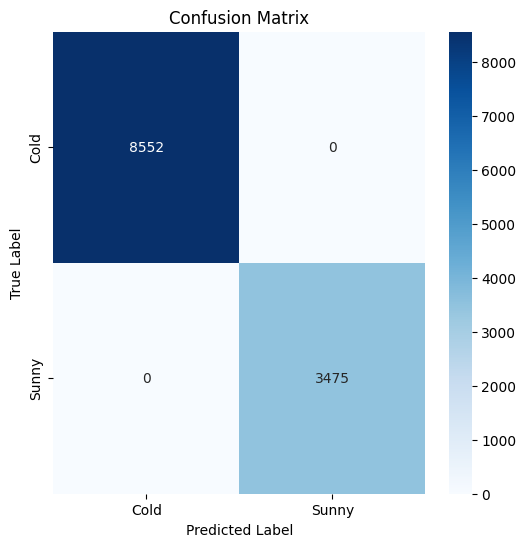

376/376 [==============================] - 1s 2ms/step

Advanced Metrics:
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

        Cold       1.00      1.00      1.00      8552
       Sunny       1.00      1.00      1.00      3475

    accuracy                           1.00     12027
   macro avg       1.00      1.00      1.00     12027
weighted avg       1.00      1.00      1.00     12027


Real-time Capability Assessment:
- Model size: 65 parameters
- Training time: 91.75 seconds
- Inference speed: 0.0931 ms per sample
- Recommended max inference time for real-time: <10ms
✅ Model meets real-time requirements

Model saved to D:\FCDS\semster 8\IOT 2\Projects\project 2\tinyml-weather-classification\models\tensorflow\weather_model.h5
Scaler saved to D:\FCDS\semster 8\IOT 2\Projects\project 2\tinyml-weather-classification\models\tensorflow\scaler.pkl


In [6]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cold', 'Sunny'], 
            yticklabels=['Cold', 'Sunny'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Additional metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict(X_test).ravel())

print("\nAdvanced Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Cold', 'Sunny']))

# Real-time capability assessment
print("\nReal-time Capability Assessment:")
print(f"- Model size: {model.count_params()} parameters")
print(f"- Training time: {train_time:.2f} seconds")
print(f"- Inference speed: {inference_time:.4f} ms per sample")
print("- Recommended max inference time for real-time: <10ms")

if inference_time < 10:
    print("✅ Model meets real-time requirements")
else:
    print("⚠️ Model may need optimization for real-time use")

# Save the trained model
model_path = r"D:\FCDS\semster 8\IOT 2\Projects\project 2\tinyml-weather-classification\models\tensorflow\weather_model.h5"
model.save(model_path)
print(f"\nModel saved to {model_path}")

# Save the scaler for later use
import joblib
scaler_path = r"D:\FCDS\semster 8\IOT 2\Projects\project 2\tinyml-weather-classification\models\tensorflow\scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")